# Electromagnetic scattering from a screen

### Background

In this tutorial we consider the scattering of an electromagnetic wave from a perfectly conducting screen $\Gamma:=[-2,2]\times[-1,1]\times0$. The time-harmonic Maxwell equation for the electric field $E$ reduces to

$$
\nabla\times\nabla\times \mathbf{E} -k^2 \mathbf{E} = 0
$$

in $\mathbb{R}^3\backslash\Gamma$, where $k:=2\pi/\lambda$ is the wavenumber and $\lambda$ is the wavelength. The electric field $\mathbf{E}$ is the sum of the incident field $\mathbf{E}^{(i)}$ and the scattered field $\mathbf{E}^{(s)}$. Here, we assume that the incident field is given by

$$
\mathbf{E}^{(i)}:=\begin{bmatrix} e^{ikz} & 0 & 0 \end{bmatrix},
$$
which is a wave travelling in the $z$ direction and polarised in the $x$ direction. On the screen the tangential component $\mathbf{E}_t:=n\times \mathbf{E}$ must be zero. Towards infinity we impose the Silver-Muller radiation condition

$$
\lim_{|\mathbf{x}|\rightarrow\infty} |\mathbf{x}|\left(\nabla\times \mathbf{E}^{(s)}\times\hat{\mathbf{x}}-ik\mathbf{E}^{(s)}\right) = 0,
$$
where $\hat{\mathbf{x}}=\mathbf{x}/|\mathbf{x}|$.

The scattered wave $\mathbf{E}^{(s)}$ has the representation

$$
\mathbf{E}^{(s)} = -\Psi_{\mathbf{SL}}(\mathbf{\lambda}),
$$

where $\lambda$ is the jump of the Neumann trace of the scattered field $\mathbf{E}^{(s)}$ across the screen. The Maxwell electric field potential operator $\Psi_{\mathbf{SL}}$ is defined as

$$
\Psi_{\mathbf{SL}}(\mathbf{v}):=ik\int_{\Gamma}G(\mathbf{x},\mathbf{y})\mathbf{v}(\mathbf{y})d\Gamma(\mathbf{y})-
\frac{1}{ik}\nabla_{\mathbf{x}}\int_{\Gamma}G(\mathbf{x},\mathbf{y})(\nabla_{\Gamma}\cdot\mathbf{v})(\mathbf{y})d\Gamma(\mathbf{y})
$$
with $G(\mathbf{x},\mathbf{y}):=\frac{e^{ik|\mathbf{x}-\mathbf{y}|}}{4\pi|\mathbf{x}-\mathbf{y}|}$.

The associated boundary operator is denoted by $\mathcal{S}$. It is obtained as average from the tangential traces of the electric field potential operator from both sides of the screen. The boundary integral equation is now

$$
\mathcal{S}\mathbf{\lambda} = n\times E^{(i)}.
$$
The $-$ sign is missing in comparison to the representation formula since we want to satisfy the boundary conditions for the negative incident wave so that the tangential trace of the total field is zero on the screen.

More details about the mathematical background can be found in the wonderful overview paper by [Buffa and Hiptmair (2003)](http://www.sam.math.ethz.ch/~hiptmair/Courses/CEM/BUH03.pdf).

### Implementation

We start with the usual imports.

In [1]:
import bempp.api
import numpy as np

To avoid preconditioning issues we assemble the operators in dense mode so that we can solve via LU decomposition later on.

In [2]:
bempp.api.global_parameters.assembly.boundary_operator_assembly_type = 'dense'

We need to define the wavenumber of the problem.

In [3]:
wavelength = .5
k = 2 * np.pi / wavelength

The function `incident_field` defines the incident wave. The function `tangential_trace` computes the tangential trace of the incident field.

In [4]:
def incident_field(x):
    return np.array([np.exp(1j * k * x[2]), 0. * x[2], 0. * x[2]])

def tangential_trace(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n, axis=0)    


We define a structured grid in the x-y plane.

In [5]:
grid = bempp.api.structured_grid((-2, -1), (2, 1), (60, 30))

A suitable space for Maxwell problems is the Raviart-Thomas space of order 0. Higher-order Raviart-Thomas spaces are currently not available in BEM++.

In [8]:
space = bempp.api.function_space(grid, "NC", 0)

In the following we define the Maxwell single-layer boundary operator and the Maxwell identity operator. For Maxwell problems the suitable inner product is not the standard $L^2$ inner product but the anti-symmetric pairing $\langle \mathbf{\mu},\mathbf{\eta}\rangle_{\mathbf{\tau},\mathbf{\Gamma}}:=\int_{\Gamma}\overline{\mathbf{\mu}(\mathbf{x})}\cdot (\mathbf{\eta}(\mathbf{x})\times n(\mathbf{x}))d\Gamma(\mathbf{x})$. Hence, the standard identity is not suitable and a specific Maxwell identity operator is defined in BEM++, which implements this pairing.

In [30]:
slp = bempp.api.operators.boundary.maxwell.electric_field(space, space, space, k)
identity = bempp.api.operators.boundary.sparse.maxwell_identity_operator(space, space, space)

AttributeError: 'module' object has no attribute 'maxwell_identity_operator'

The following command creates a grid function from the tangential trace.

In [18]:
trace_fun = bempp.api.GridFunction(space, fun=tangential_trace)

We have to multiply the GridFunction `trace_data` with the Maxwell mass matrix `id` in order to obtain the anti-symmetric dual pairing of the basis functions with the incident wave.

In [19]:
rhs = identity * trace_fun

NameError: name 'identity' is not defined

We use a direct solver to solve the system. It is not a large problem and Krylov methods without preconditioning converge poorly for the electric field integral equation.

In [20]:
from bempp.api.linalg import lu
lambda_data = lu(slp, rhs)

NameError: name 'rhs' is not defined

Now that the solution $\mathbf{\lambda}$ is computed we want to plot the total field. First, we define a grid of points in the x-z plane.

In [21]:
# Create a grid of points

nx = 151
nz = 151
extent = 5
x, y, z = np.mgrid[-extent:extent:nx * 1j, 0:0:1j, -extent:extent:nz * 1j]
points = np.vstack((x.ravel(), y.ravel(), z.ravel()))


We now initialize the single-layer potential operator. By default potentials are assembled using accelerated H-Matrix techniques. Here, we set the accuracy of the assembly to 1E-2. This is quite low but sufficient for plotting accuracy.

In [25]:
bempp.api.global_parameters.hmat.eps = 1E-2
slp_pot = bempp.api.operators.potential.maxwell.electric_field(space, points, k)

The following commands now compute the total field by first computing the scattered field from the representation formula and then summing into it the incident field.

In [26]:
scattered_field_data = -slp_pot * lambda_data
incident_field_data = incident_field(points)
field_data = scattered_field_data + incident_field_data

NameError: name 'lambda_data' is not defined

In electromagnetic scattering it is often useful to visualize the squared electric field density. This value is computed below.

In [24]:
squared_field_density = np.real(np.sum(field_data * field_data.conj(), axis=0))

NameError: name 'field_data' is not defined

Finally, we can plot everything using a simple Matplotlib plot.

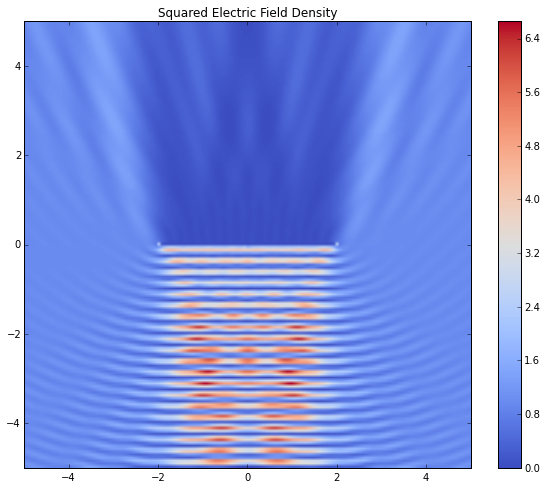

In [15]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
# Adjust the figure size in IPython
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0) 

plt.imshow(squared_field_density.reshape((nx,nz)).T,
           cmap='coolwarm', origin='lower',
           extent=[-extent, extent, -extent,extent])
plt.colorbar()
plt.title("Squared Electric Field Density")